# <center> Baseline ResNet

Nous allons utiliser ResNet pour nous créer une baseline de comparaison, mais également pour comparer les performances avec la partie vision.

## Imports de base

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [35]:
import sys
from pathlib import Path

# Pour que notre archi fonctionne avec google colab 
    
!git clone https://github.com/julietteabalain-cloud/Reconnaissance-de-mouvement-artistique.git
!cd /content/Reconnaissance-de-mouvement-artistique && git pull
%cd /content/Reconnaissance-de-mouvement-artistique 
import sys
sys.path.append(".")  # pour que src/ soit importable

PROJECT_ROOT = Path().resolve().parent
sys.path.append(str(PROJECT_ROOT))
DATA_ROOT = PROJECT_ROOT / "data"

Cloning into 'Reconnaissance-de-mouvement-artistique'...
remote: Enumerating objects: 360, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 360 (delta 56), reused 57 (delta 30), pack-reused 272 (from 2)
Receiving objects: 100% (360/360), 99.20 MiB | 16.99 MiB/s, done.
Resolving deltas: 100% (209/209), done.
Already up to date.
/content/Reconnaissance-de-mouvement-artistique


In [36]:
from src.dataset_dl import ArtDataset
from src.train import train_model, train_one_epoch, validate_one_epoch

from src.dataset import load_df_train_test_val, load_df
from src.preprocessing import clean_dataset

from src.models import get_resnet18
from src.evaluate import compute_confusion_matrix, plot_confusion_matrix, accuracy_per_class, visualize_accuracy_per_style, evaluate_model
from src.utils import set_seed

#Fixer l'initialisation aléatoire pour la reproductibilité
set_seed(42)

#pour avoir acces au GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



ImportError: cannot import name 'evaluate_model' from 'src.evaluate' (/content/Reconnaissance-de-mouvement-artistique/src/evaluate.py)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from pathlib import Path

PROJECT_ROOT = Path("/content/deepl-projet")
DATA_ROOT = Path("/content/drive/MyDrive/DeepLearning/WikiArt_Subset")


df_test, df_train, df_val = load_df_train_test_val(DATA_ROOT)
df = load_df(DATA_ROOT)

df, df_train, df_val, df_test = clean_dataset(df, df_train, df_val, df_test)

Mounted at /content/drive


/content/Reconnaissance-de-mouvement-artistique/src/preprocessing.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["style_encoded"] = le.fit_transform(df_train["style"])
/content/Reconnaissance-de-mouvement-artistique/src/preprocessing.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["style_encoded"]   = le.transform(df_val["style"])
/content/Reconnaissance-de-mouvement-artistique/src/preprocessing.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

## 1. Partie Classique / Baseline

### 1.1 Préparation du dataset

On ajoute de la data augmentation pour éviter le surapprentissage.

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ), 
    # ajout de data augmentation pour le training set
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ), 
])


In [ ]:
IMAGE_ROOT_TRAIN = DATA_ROOT / "train"
IMAGE_ROOT_VAL = DATA_ROOT / "val"
IMAGE_ROOT_TEST = DATA_ROOT / "test"

train_dataset = ArtDataset(
    df_train,
    IMAGE_ROOT_TRAIN,
    transform=transform_train
)

val_dataset = ArtDataset(
    df_val,
    IMAGE_ROOT_VAL,
    transform=transform_val
)

test_dataset = ArtDataset(
    df_test,
    IMAGE_ROOT_TEST,
    transform=transform_val
)


In [ ]:
BATCH_SIZE = 32  

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,     # ajuster selon ton CPU
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,     # ajuster selon ton CPU
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,     # ajuster selon ton CPU
    pin_memory=True
)

### 1.2 Charger le modèle

In [30]:
num_classes = df_train["style"].nunique()
print("Min label:", df_train["style"].min())
print("Max label:", df_train["style"].max())
print("Nombre de classes uniques:", df_train["style"].nunique())


print(str(df_train["style"].nunique()))
model = get_resnet18(num_classes=num_classes, device=device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.fc.parameters(),
    lr=1e-3
)


Min label: 0
Max label: 26
Nombre de classes uniques: 23
23


### 1.3 Entrainement du modèle

On commence avec 3 epoch et on freeze.

In [26]:
row = df_train.iloc[0]

print(row["filename"])
print(row["style"])
print(row["style_encoded"])

print(row["style_name"])
print(df_train[["style","style_name"]].head(10))

print((IMAGE_ROOT_TRAIN / str(row["style"]) / row["filename"]).exists())
print((IMAGE_ROOT_TRAIN / str(row["style_encoded"]) / row["filename"]).exists())

2289.jpg
9
7
Expressionism
    style              style_name
1       9           Expressionism
2      10                 Fauvism
4      24               Symbolism
5       0  Abstract_Expressionism
6      10                 Fauvism
7      11        High_Renaissance
8       5    Color_Field_Painting
9      26                 Ukiyo_e
10      6    Contemporary_Realism
11      9           Expressionism
True
False


In [27]:
history_freeze = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=3
)



Epoch 1/3


KeyboardInterrupt: 

unfreeze complet :

In [ ]:
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4
)


On continue avec cette fois 10 epoch.

In [ ]:
history_unfreeze = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=10
)



Epoch 1/10


Train Loss: 1.6170 | Train Acc: 0.4850 | Val Loss: 1.5780 | Val Acc: 0.4916

Epoch 2/10


Train Loss: 0.7173 | Train Acc: 0.8063 | Val Loss: 1.5630 | Val Acc: 0.5178

Epoch 3/10


Train Loss: 0.2744 | Train Acc: 0.9578 | Val Loss: 1.5616 | Val Acc: 0.5324

Epoch 4/10


Train Loss: 0.1011 | Train Acc: 0.9927 | Val Loss: 1.5817 | Val Acc: 0.5375

Epoch 5/10


Train Loss: 0.0528 | Train Acc: 0.9949 | Val Loss: 1.6125 | Val Acc: 0.5492

Epoch 6/10


Train Loss: 0.0346 | Train Acc: 0.9964 | Val Loss: 1.6431 | Val Acc: 0.5484

Epoch 7/10


Train Loss: 0.0292 | Train Acc: 0.9963 | Val Loss: 1.6805 | Val Acc: 0.5441

Epoch 8/10


Train Loss: 0.0253 | Train Acc: 0.9953 | Val Loss: 1.6976 | Val Acc: 0.5492

Epoch 9/10


Train Loss: 0.0202 | Train Acc: 0.9961 | Val Loss: 1.7473 | Val Acc: 0.5448

Epoch 10/10


Train Loss: 0.0349 | Train Acc: 0.9918 | Val Loss: 1.9127 | Val Acc: 0.5084


### 1.4 Evaluation du modèle

Accuracy (précision)  globale :

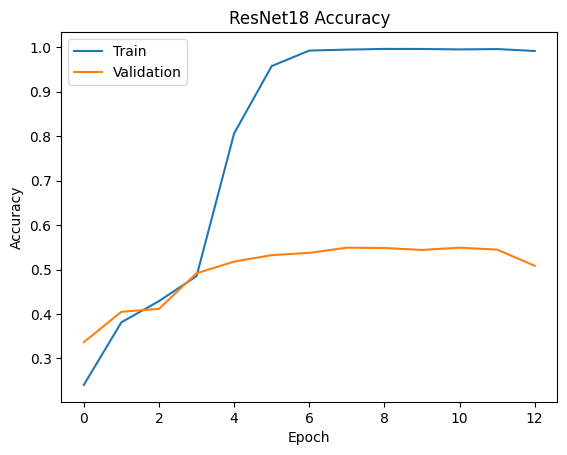

In [14]:
train_acc = history_freeze["train_acc"] + history_unfreeze["train_acc"]
val_acc   = history_freeze["val_acc"]   + history_unfreeze["val_acc"]

plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(["Train", "Validation"])
plt.title("ResNet18 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


Matrice de confusion :

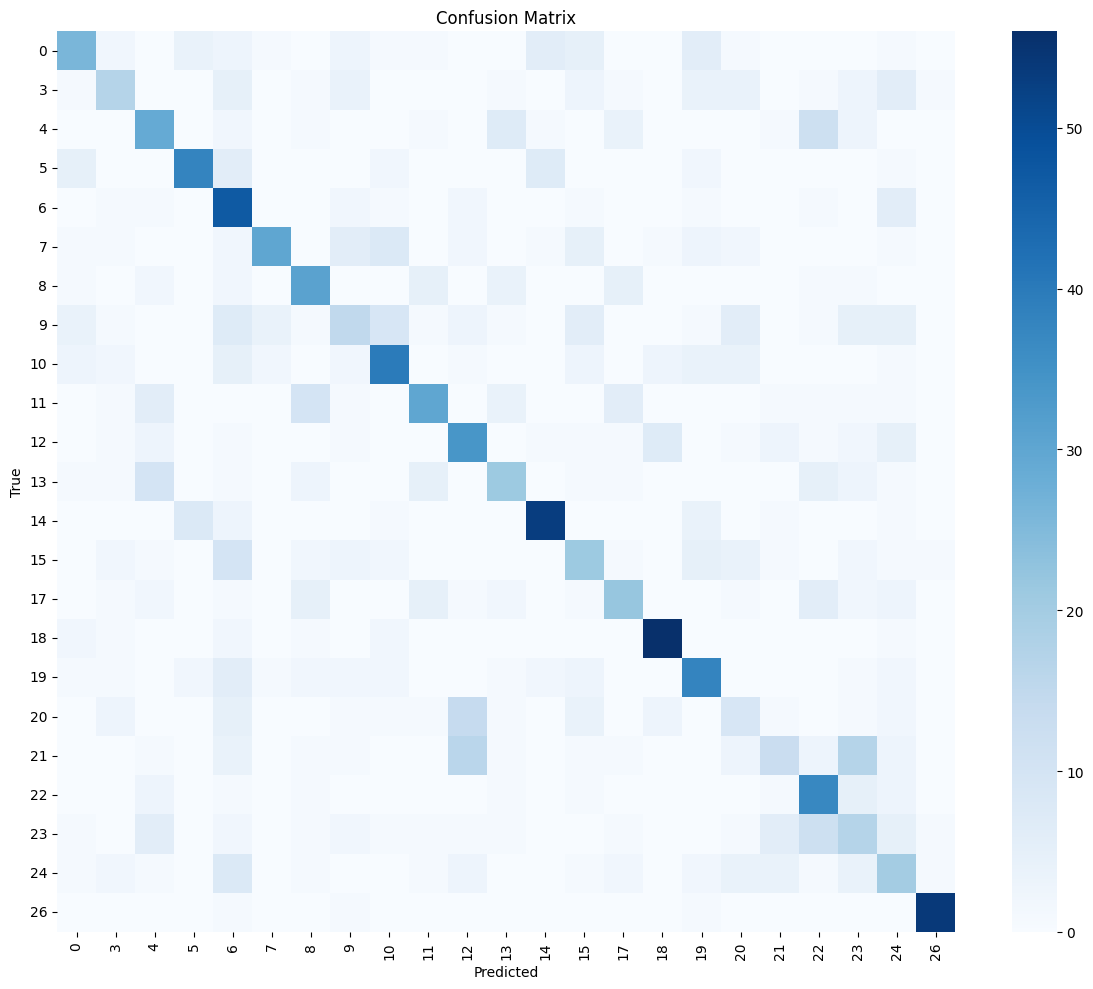

In [15]:
#Confusion matrix :

class_names = sorted(df_train["style"].unique())

cm = compute_confusion_matrix(
    model,
    val_loader,
    device,
    class_names
)

plot_confusion_matrix(cm, class_names)


Accuracy par style :

In [16]:
class_names = sorted(df_train["style"].unique())

acc_per_style = accuracy_per_class(
    model,
    val_loader,
    device,
    class_names
)

results = list(zip(class_names, acc_per_style))
results = sorted(results, key=lambda x: x[1], reverse=True)

for style, acc in results:
    print(f"{style}: {acc:.3f}")


26: 0.947
18: 0.862
14: 0.746
6: 0.746
22: 0.698
5: 0.623
8: 0.596
19: 0.594
10: 0.571
12: 0.548
11: 0.484
7: 0.476
4: 0.475
0: 0.433
17: 0.423
13: 0.396
15: 0.375
24: 0.357
3: 0.327
23: 0.288
9: 0.214
21: 0.200
20: 0.196


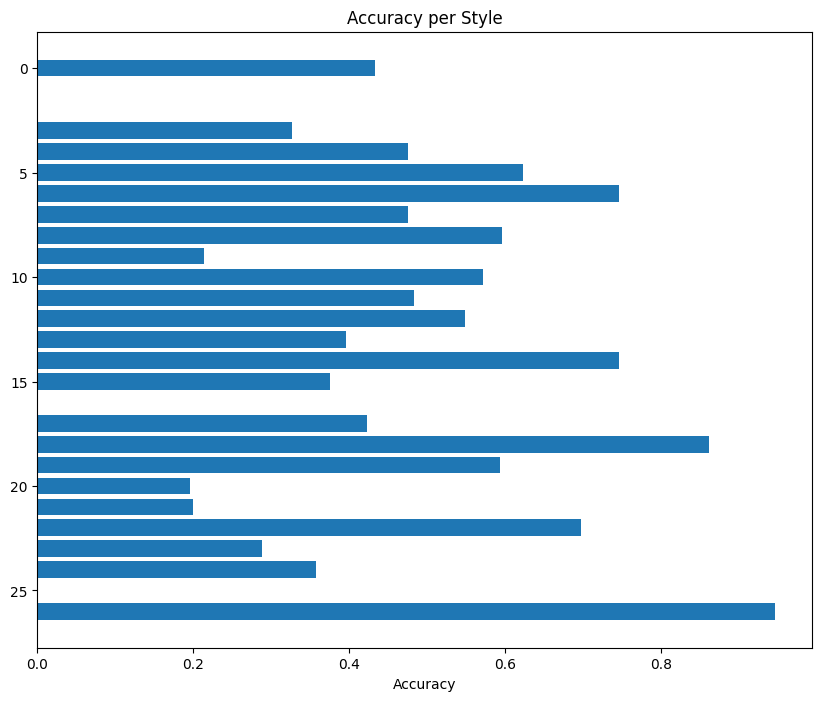

In [17]:
visualize_accuracy_per_style(results)

### 1.5 Second modèle ResNet18

Surapprentissage très fort; modèle utilisé : Freeze 3 epochs, Unfreeze tout 10 epochs à 1e-4
On change de stratégie : 

In [ ]:
model_02 = get_resnet18(num_classes=num_classes, device=device, drop=True)

# ajout de label smoothing pour la cross entropy loss
# label smoothing permet de rendre le modèle moins confiant dans ses prédictions, 
# ce qui peut aider à améliorer la généralisation et réduire le surapprentissage
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.Adam(
    model_02.fc.parameters(),  
    lr=1e-3,
    weight_decay=1e-4
)

In [32]:
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.best_loss = float("inf")
        self.counter = 0
        self.stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

In [33]:
# from src.utils import EarlyStopping

early_stopping = EarlyStopping(patience=3)

NUM_EPOCHS_FREEZE = 3
history_freeze_02 = train_model(
    model_02,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=NUM_EPOCHS_FREEZE,
    early_stopping=early_stopping  
)

# Débloquer layer4 et fc pour le fine-tuning
for param in model_02.parameters():
    param.requires_grad = False
for param in model_02.layer4.parameters():
    param.requires_grad = True
for param in model_02.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(
    model_02.parameters(),
    lr=1e-4, 
    weight_decay=1e-4)

NUM_EPOCHS_UNFREEZE = 5

history_unfreeze_02 = train_model(
    model_02,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=NUM_EPOCHS_UNFREEZE,
    early_stopping=early_stopping
)




Epoch 1/3


Train Loss: 3.5586 | Train Acc: 0.1665 | Val Loss: 3.1240 | Val Acc: 0.2819

Epoch 2/3


Train Loss: 3.1201 | Train Acc: 0.2706 | Val Loss: 2.9619 | Val Acc: 0.3219

Epoch 3/3


Train Loss: 3.0005 | Train Acc: 0.3115 | Val Loss: 2.9534 | Val Acc: 0.3190

Epoch 1/5


Train Loss: 2.8166 | Train Acc: 0.3636 | Val Loss: 2.6862 | Val Acc: 0.4013

Epoch 2/5


Train Loss: 2.4919 | Train Acc: 0.4714 | Val Loss: 2.6238 | Val Acc: 0.4181

Epoch 3/5


Train Loss: 2.2929 | Train Acc: 0.5402 | Val Loss: 2.6181 | Val Acc: 0.4195

Epoch 4/5


Train Loss: 2.1126 | Train Acc: 0.6054 | Val Loss: 2.6324 | Val Acc: 0.4312

Epoch 5/5


Train Loss: 1.9633 | Train Acc: 0.6654 | Val Loss: 2.6638 | Val Acc: 0.4188


### 1.6 Evaluation du nouveau modèle 

#### 1.6.1 Evaluation avec train + val

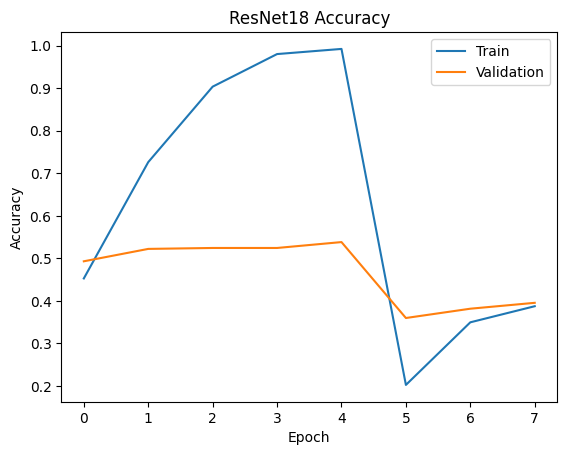

In [16]:
train_acc = history_unfreeze_02["train_acc"] + history_freeze_02["train_acc"]
val_acc   = history_unfreeze_02["val_acc"] + history_freeze_02["val_acc"]

plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(["Train", "Validation"])
plt.title("ResNet18 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

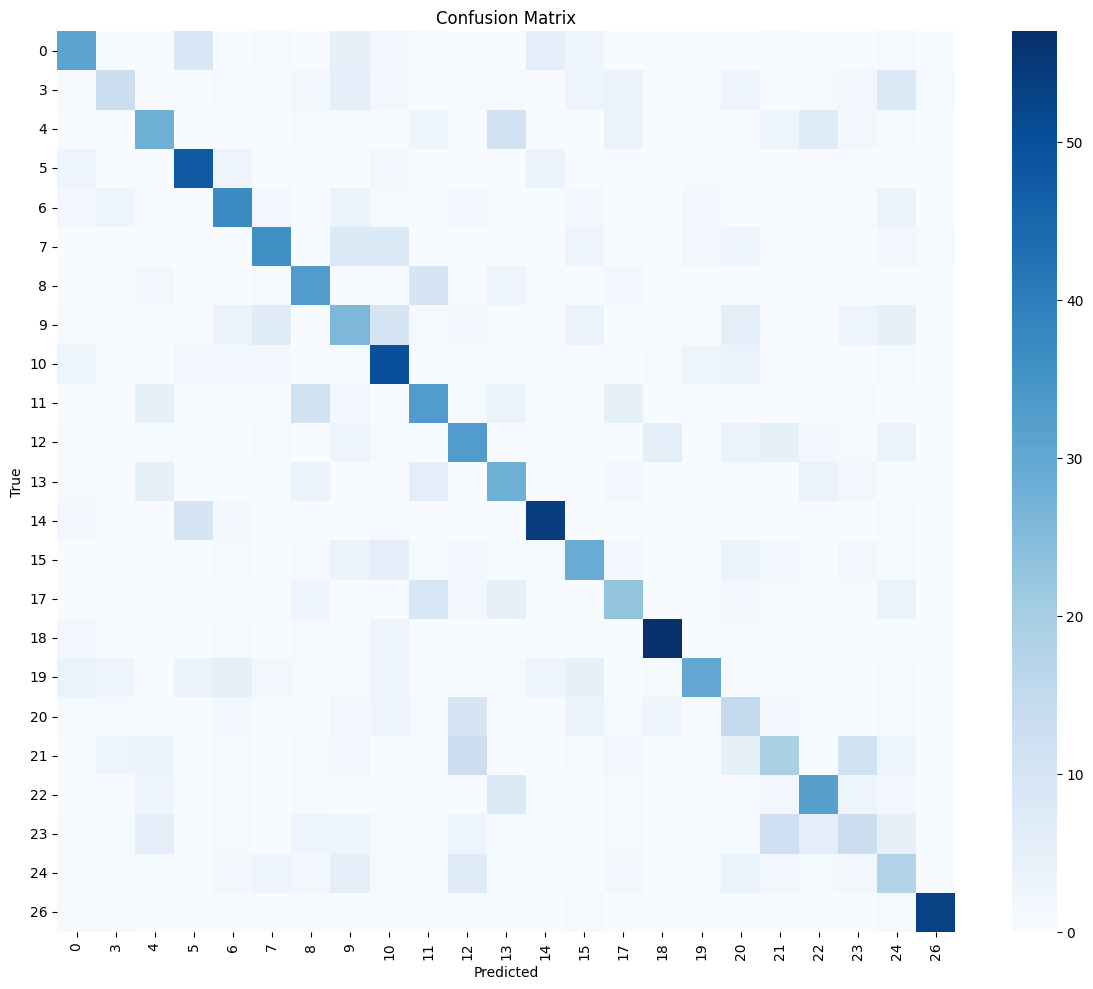

In [17]:
#Confusion matrix :

class_names = sorted(df_train["style"].unique())

cm = compute_confusion_matrix(
    model_02,
    val_loader,
    device,
    class_names
)

plot_confusion_matrix(cm, class_names)


In [18]:
class_names = sorted(df_train["style"].unique())

acc_per_style = accuracy_per_class(
    model_02,
    val_loader,
    device,
    class_names
)

results = list(zip(class_names, acc_per_style))
results = sorted(results, key=lambda x: x[1], reverse=True)

for style, acc in results:
    print(f"{style}: {acc:.3f}")


26: 0.930
18: 0.877
5: 0.787
14: 0.761
10: 0.714
8: 0.635
22: 0.604
6: 0.587
7: 0.571
11: 0.532
12: 0.532
13: 0.528
15: 0.518
0: 0.517
19: 0.469
4: 0.459
17: 0.442
9: 0.371
20: 0.326
24: 0.321
21: 0.292
3: 0.250
23: 0.220


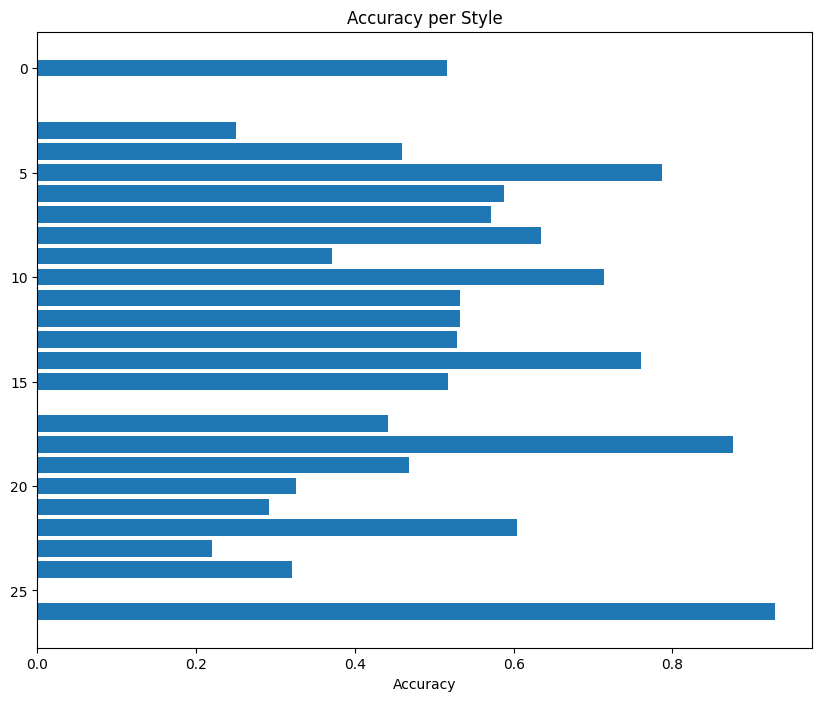

In [19]:
visualize_accuracy_per_style(results)

#### 1.6.2 Evaluation sur l'ensemble de test

In [ ]:
best_model_weights = model_02.state_dict()

test_acc, test_cm, report = evaluate_model(model_02, test_loader, device)

print(f"Test Accuracy: {test_acc:.3f}")
print("Classification Report:")
print(report)

In [ ]:
print("Test Confusion Matrix:")
print(test_cm)

### 1.5 Sauvegarde du modèle entrainé

In [ ]:
import os
SAVE_DIR = "/content/drive/MyDrive/models"
model_name_02 = "resnet18_baseline_02.pt"
os.makedirs("/content/drive/MyDrive/models", exist_ok=True)

save_path = os.path.join(SAVE_DIR, model_name_02)

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "num_classes": num_classes,
    "learning_rate": 1e-3,
    "weight_decay": 1e-4,
    "batch_size": train_loader.batch_size,
    "num_epochs": len(history_02["train_loss"]),
    "history": history_02,
    "architecture": "resnet18_baseline_frozen_dropout",
}, save_path)

# Pour charger le modèle plus tard :
# checkpoint = torch.load(save_path, map_location=device)

# model = get_resnet18(
#     num_classes=checkpoint["num_classes"],
#     device=device
# )

# model.load_state_dict(checkpoint["model_state_dict"])

# model.eval()



🔹 Phase B – Préparer l’infrastructure pour ablation

 Créer fonction apply_low_pass(image)

 Créer fonction apply_high_pass(image)

 Version dataset avec filtrage optionnel

 Réentraîner ResNet sur chaque version

 Comparer accuracy globale

 Comparer accuracy par style

 Graphique comparatif final